In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from timeit import default_timer as timer
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("VARIMA_OHLC_USDPHP.csv")
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2922 non-null   object 
 1   Open    2922 non-null   float64
 2   High    2922 non-null   float64
 3   Low     2922 non-null   float64
 4   Close   2922 non-null   float64
dtypes: float64(4), object(1)
memory usage: 114.3+ KB


,Date,Open,High,Low,Close
0,03/01/2017 9:00,49.700,49.825,49.70,49.780
1,03/01/2017 13:00,49.775,49.800,49.77,49.780
2,04/01/2017 9:00,49.800,49.850,49.73,49.730
3,04/01/2017 13:00,49.715,49.765,49.67,49.685
4,05/01/2017 9:00,49.595,49.700,49.54,49.615


### Data Pre-Processing

In [4]:
df = data.replace(',', '', regex=True)
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)



### Splitting the Original Data

In [6]:
train_percentage = 0.8
test_percentage = 1 - train_percentage 
train_size_orig_data= int(len(df) * train_percentage)
df_train_orig = df.iloc[:train_size_orig_data] #train set
df_test_orig = df.iloc[train_size_orig_data:] #test set
df_train_orig_graph = df_train_orig[['Open', 'High', 'Low', 'Close']]
df_test_orig_graph = df_test_orig[['Open', 'High', 'Low', 'Close']]

In [8]:
df_train_orig 

,Date,Open,High,Low,Close
0,03/01/2017 9:00,49.700,49.825,49.700,49.780
1,03/01/2017 13:00,49.775,49.800,49.770,49.780
2,04/01/2017 9:00,49.800,49.850,49.730,49.730
3,04/01/2017 13:00,49.715,49.765,49.670,49.685
4,05/01/2017 9:00,49.595,49.700,49.540,49.615
...,...,...,...,...,...
2332,19/10/2021 9:00,50.833,50.882,50.725,50.736
2333,19/10/2021 13:00,50.737,50.737,50.685,50.730
2334,20/10/2021 9:00,50.698,50.840,50.698,50.810
2335,20/10/2021 13:00,50.785,50.823,50.773,50.807


### Plot of the Original Data

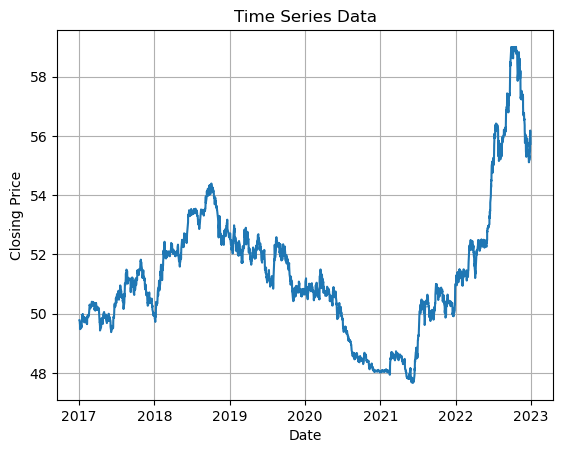

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')

# Step 3: Create the plot

plt.plot(df['Date'], df['Close'])

# Step 4: Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Data')
plt.grid(True)

# Step 5: Display the plot
plt.show()

### Checking the Stationarity of the Data

### OHLC

In [9]:
#Open
result = adfuller(df['Open'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Open")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

#High
result = adfuller(df['High'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:High")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

#Low
result = adfuller(df['Low'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Low")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

#Close
result = adfuller(df['Close'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Close")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

Dickey-Fuller test for feature:Open
Test Statistic: -0.897066
p-value: 0.788937
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject H0 - Time Series is Non-Stationary
Dickey-Fuller test for feature:High
Test Statistic: -0.843672
p-value: 0.805956
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject H0 - Time Series is Non-Stationary
Dickey-Fuller test for feature:Low
Test Statistic: -0.758761
p-value: 0.830937
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject H0 - Time Series is Non-Stationary
Dickey-Fuller test for feature:Close
Test Statistic: -0.835968
p-value: 0.808328
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to Reject H0 - Time Series is Non-Stationary


### Mitigating the Problem of Non-Stationarity through Differencing

In [10]:
df['Close_diff'] = df['Close'].diff()
df['Open_diff'] = df['Open'].diff()
df['Low_diff'] = df['Low'].diff()
df['High_diff'] = df['High'].diff()
df = df.dropna()
df.shape
data_uti=df[['Date','Open_diff','Close_diff','Low_diff','High_diff']]
## Renaming the Columns of the Table
data_uti.rename(
    columns={"Open_diff": "Open", "Close_diff": "Close","High_diff":"High","Low_diff": "Low"},
    inplace=True,
)
data_uti=data_uti.reset_index(drop=True)
data_uti[:2]

,Date,Open,Close,Low,High
0,03/01/2017 13:00,0.075,0.00,0.07,-0.025
1,04/01/2017 9:00,0.025,-0.05,-0.04,0.050


### Plot of the Differenced Data

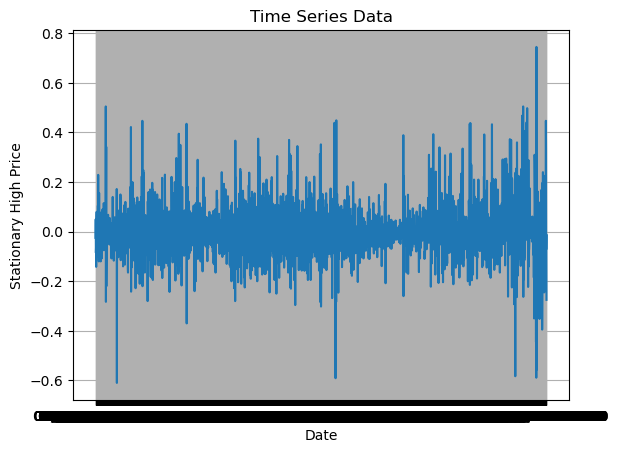

In [11]:
plt.plot(data_uti['Date'], data_uti['High'])

# Step 4: Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Stationary High Price')
plt.title('Time Series Data')
plt.grid(True)

# Step 5: Display the plot
plt.show()

### Checking the Stationarity again through AD-Fuller test

In [12]:
#Open
result = adfuller(data_uti['Open'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Open after Differencing")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")


#High
result = adfuller(data_uti['High'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:High after Differencing")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

#Low
result = adfuller(data_uti['Low'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Low after Differencing")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")

#Close
result = adfuller(data_uti['Close'].values)
#Extracting the values from the results:
print("Dickey-Fuller test for feature:Close after Differencing")

print('Test Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Failed to Reject H0 - Time Series is Non-Stationary")


Dickey-Fuller test for feature:Open after Differencing
Test Statistic: -11.928929
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary
Dickey-Fuller test for feature:High after Differencing
Test Statistic: -12.341430
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary
Dickey-Fuller test for feature:Low after Differencing
Test Statistic: -15.652120
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary
Dickey-Fuller test for feature:Close after Differencing
Test Statistic: -15.079850
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary


### Splitting the Differenced Data

In [14]:
train_size = int(len(data_uti) * train_percentage)
test_size = int(len(data_uti) * test_percentage)

df_train_diff = data_uti.iloc[:train_size]

df_test_diff = data_uti.iloc[train_size:]

train_data_diff = df_train_diff.reset_index(drop=True)
test_data_diff = df_test_diff.reset_index(drop=True)



,Date,Open,Close,Low,High
0,03/01/2017 13:00,0.075,0.000,0.070,-0.025
1,04/01/2017 9:00,0.025,-0.050,-0.040,0.050
2,04/01/2017 13:00,-0.085,-0.045,-0.060,-0.085
3,05/01/2017 9:00,-0.120,-0.070,-0.130,-0.065
4,05/01/2017 13:00,-0.037,-0.140,-0.107,-0.142
...,...,...,...,...,...
2331,19/10/2021 9:00,-0.047,-0.109,-0.115,-0.006
2332,19/10/2021 13:00,-0.096,-0.006,-0.040,-0.145
2333,20/10/2021 9:00,-0.039,0.080,0.013,0.103
2334,20/10/2021 13:00,0.087,-0.003,0.075,-0.017


### Data Training

### Open

In [15]:
target_variable_open = 'Open'

# Extract the time series data for the target variable
ts_open = train_data_diff[target_variable_open]


# Apply auto_arima to find the best ARIMA model
stepwise_model_open = auto_arima(ts_open, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_open.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4471.300, Time=1.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4449.398, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4453.969, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4454.274, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4451.331, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4450.321, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4455.146, Time=1.00 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-4471.448, Time=0.99 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-4471.566, Time=1.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-4468.226, Time=0.98 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-4473.579, Time=1.52 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-4474.911, Time=0.49 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-4473.825, Time=0.66 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-4471.832, Time=0.98 sec
 ARIMA(4,0,0)(0,0,0

### High

In [16]:
target_variable_high = 'High'

# Extract the time series data for the target variable
ts_high = train_data_diff[target_variable_high]
tst_high= test_data_diff[target_variable_high]

# Apply auto_arima to find the best ARIMA model
stepwise_model_high = auto_arima(ts_high, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_high.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4461.133, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4460.654, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4460.657, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4463.079, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4458.657, Time=0.61 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.161 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2336
Model:                        SARIMAX   Log Likelihood                2232.540
Date:                Sat, 06 Apr 2024   AIC                          -4463.079
Time:                        23:20:41   BIC                          -4457.323
Sample:                             0   HQIC                         -4460.982
          

In [18]:
### The autoarima of High by limitting the order. 

target_variable_high = 'High'
ts_high = train_data_diff[target_variable_high]

best_model_high= auto_arima(ts_high, start_p=0, d=1, start_q=0,
           max_p=0, max_d=2, max_q=1, seasonal=False,
           trace=True, suppress_warnings=True, stepwise=False)
best_model_high_fit = best_model_high.fit(ts_high)
print(best_model_high.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2900.212, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.317 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2336
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1452.106
Date:                Sat, 06 Apr 2024   AIC                          -2900.212
Time:                        23:20:55   BIC                          -2888.700
Sample:                             0   HQIC                         -2896.018
                               - 2336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inter

### Low

In [22]:
target_variable_low = 'Low'

# Extract the time series data for the target variable
ts_low = train_data_diff[target_variable_low]

# Apply auto_arima to find the best ARIMA model
stepwise_model_low = auto_arima(ts_low, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_low.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4461.131, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4449.356, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4450.969, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4451.048, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4451.300, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4450.252, Time=1.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4449.066, Time=0.93 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-4494.854, Time=2.41 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-4490.206, Time=2.69 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-4485.5

### Close

In [20]:
target_variable_close = 'Close'

# Extract the time series data for the target variable
ts_close = train_data_diff[target_variable_close]

# Apply auto_arima to find the best ARIMA model
stepwise_model_close = auto_arima(ts_close, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(stepwise_model_close.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4567.532, Time=1.90 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4553.750, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4557.720, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4558.316, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4555.690, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4559.024, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4559.412, Time=0.96 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-4561.806, Time=1.95 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-4567.881, Time=1.99 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-4557.227, Time=0.50 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-4568.382, Time=1.81 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-4565.912, Time=2.39 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-4565.755, Time=2.96 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-4563.195, Time=2.48 sec
 ARIMA(4,0,2)(0,0,0

## List of order (p,q) from auto arima

In [21]:
print(stepwise_model_open.summary())
print(best_model_high.summary())
print(stepwise_model_low.summary())
print(stepwise_model_close.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2336
Model:               SARIMAX(4, 0, 0)   Log Likelihood                2243.423
Date:                Sat, 06 Apr 2024   AIC                          -4476.845
Time:                        23:22:06   BIC                          -4448.064
Sample:                             0   HQIC                         -4466.360
                               - 2336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0568      0.013      4.330      0.000       0.031       0.083
ar.L2         -0.0221      0.016     -1.375      0.169      -0.054       0.009
ar.L3         -0.0864      0.017     -4.969      0.0

### Manual ARIMA

### ACF and PACF Plots

### Open

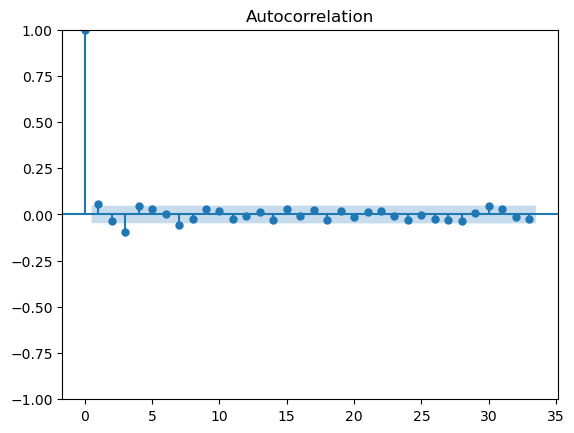

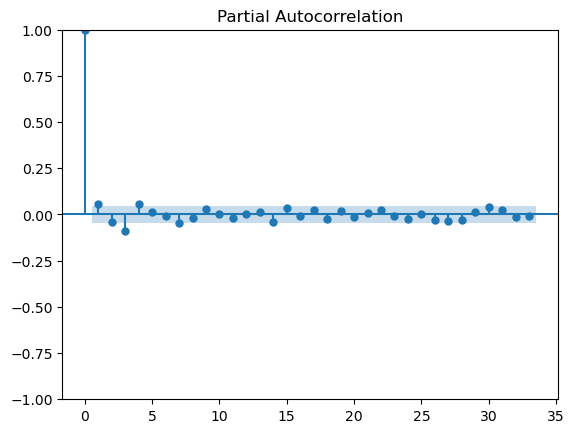

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_diff_open = plot_acf(ts_open)

pacf_diff_open = plot_pacf(ts_open)

### High

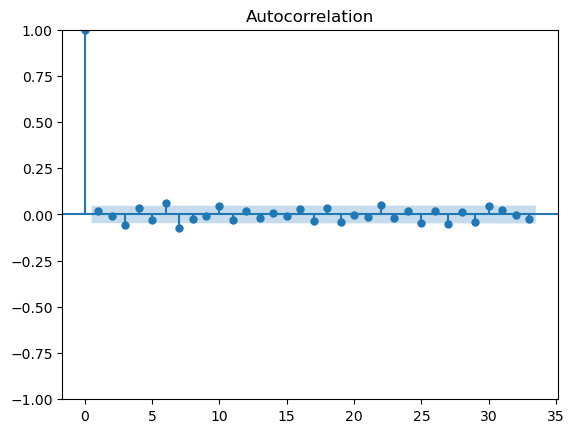

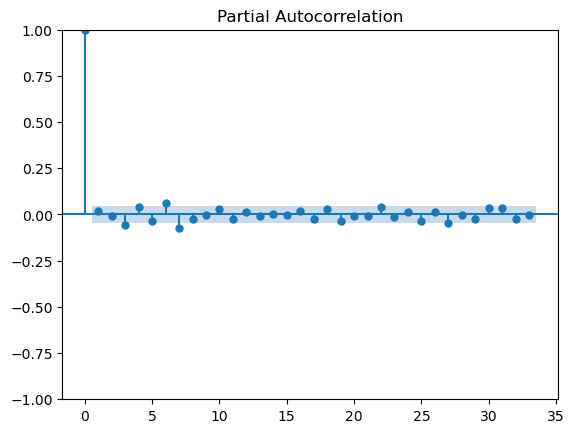

In [18]:
acf_diff_high = plot_acf(ts_high)

pacf_diff_high = plot_pacf(ts_high)

### Low

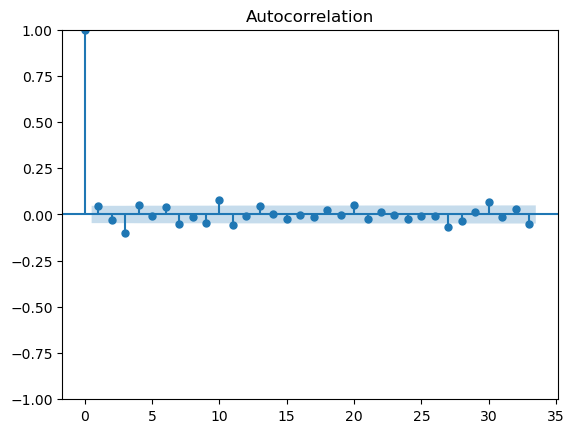

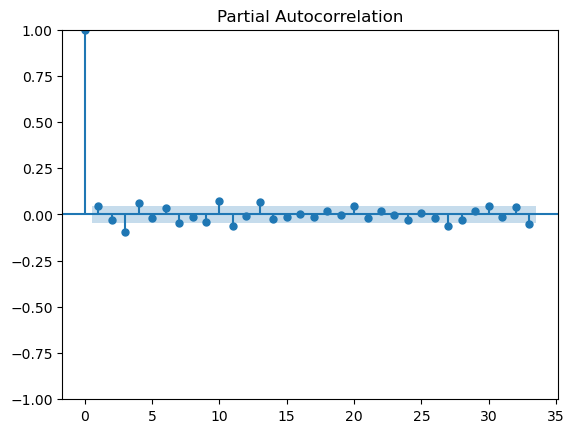

In [19]:
acf_diff_low = plot_acf(ts_low)

pacf_diff_low = plot_pacf(ts_low)

### Close

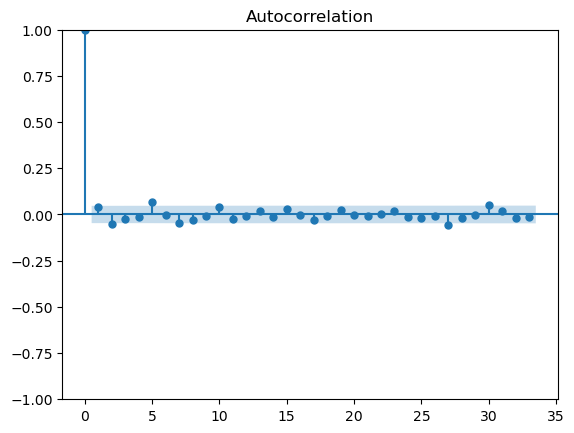

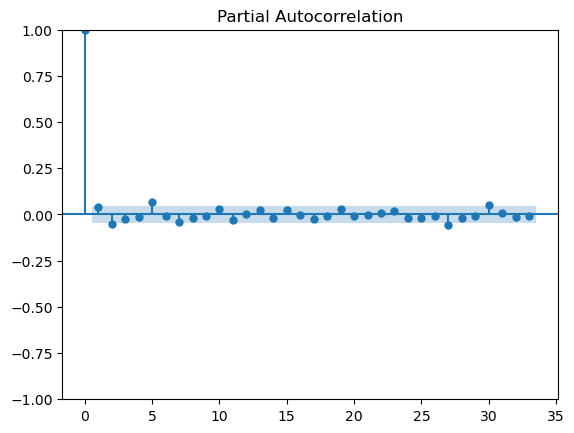

In [20]:
acf_diff_close = plot_acf(ts_close)

pacf_diff_close = plot_pacf(ts_close)

## Fit the ARIMA model Manually

###  For Open Prices

In [21]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_open, order=(3,0,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1752
Model:                 ARIMA(3, 0, 3)   Log Likelihood                1609.620
Date:                Sat, 30 Mar 2024   AIC                          -3203.241
Time:                        02:47:18   BIC                          -3159.493
Sample:                             0   HQIC                         -3187.070
                               - 1752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.080      0.936      -0.005       0.004
ar.L1         -0.5376      0.219     -2.455      0.014      -0.967      -0.108
ar.L2         -0.5095      0.118     -4.311      0.0

In [22]:
### For High Prices

In [23]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_high, order=(7,0,7))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                 1752
Model:                 ARIMA(7, 0, 7)   Log Likelihood                1609.860
Date:                Sat, 30 Mar 2024   AIC                          -3187.720
Time:                        02:47:24   BIC                          -3100.224
Sample:                             0   HQIC                         -3155.377
                               - 1752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.201      0.840      -0.005       0.004
ar.L1          0.7074      0.203      3.486      0.000       0.310       1.105
ar.L2         -0.4441      0.165     -2.685      0.0

### For Low Prices

In [24]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_low, order=(4,0,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                 1752
Model:                 ARIMA(4, 0, 3)   Log Likelihood                1614.499
Date:                Sat, 30 Mar 2024   AIC                          -3210.998
Time:                        02:47:26   BIC                          -3161.782
Sample:                             0   HQIC                         -3192.806
                               - 1752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.309      0.757      -0.006       0.004
ar.L1          0.0935      0.318      0.295      0.768      -0.529       0.716
ar.L2          0.2370      0.251      0.944      0.3

### For Close Prices

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_close, order=(5,0,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1752
Model:                 ARIMA(5, 0, 5)   Log Likelihood                1625.938
Date:                Sat, 30 Mar 2024   AIC                          -3227.877
Time:                        02:47:30   BIC                          -3162.255
Sample:                             0   HQIC                         -3203.620
                               - 1752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.006     -0.065      0.948      -0.012       0.011
ar.L1         -0.0874      0.100     -0.876      0.381      -0.283       0.108
ar.L2          0.0249      0.089      0.281      0.7

### Testing ARIMA

In [24]:
train_data_diff_nd =train_data_diff.drop('Date',axis=1)
test_data_diff_nd= test_data_diff.drop('Date',axis=1)

### For Open Prices

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_open = train['Open']
    
    # Fit ARIMA model
    model = ARIMA(train_open, order=(3, 0, 3))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_open = pd.DataFrame({"Pred_Open": yhat})
    
    return pred_open

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_open = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)


In [28]:
arima_3_3 = df_arima_pred_open.reset_index(drop=True)
validation_3_3=pd.DataFrame(arima_3_3)
validation_3_3

,Pred_Open
0,0.001581
1,0.005371
2,-0.005630
3,-0.001002
4,0.000171
...,...
579,-0.000188
580,-0.000188
581,-0.000188
582,-0.000188


### Reference for Cumsum

In [29]:
original_train=df_train_orig.iloc[:,1:5]
original_train=original_train.reset_index(drop=True)
# original_test = original_test.astype(float)
new_column_names = ['Pred_Open','Pred_High','Pred_Low','Pred_Close']
original_train.columns=new_column_names
original_train

last_row = original_train.iloc[-1]
last_row_df = pd.DataFrame(last_row).T  # Transpose the row to create a DataFrame with one row

last_row_df

,Pred_Open,Pred_High,Pred_Low,Pred_Close
1752,49.007,49.007,48.92,48.955


In [30]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_open_value = last_row_df["Pred_Open"].iloc[-1]

# Create a DataFrame with the last value
last_pred_open_df = pd.DataFrame([last_pred_open_value], columns=["Pred_Open"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_open_true_3_3 = pd.concat([last_pred_open_df, validation_3_3], ignore_index=True)
arima_cumsum_open_3_3 = arima_pred_open_true_3_3.cumsum()
arima_cumsum_open_3_3= arima_cumsum_open_3_3.drop(index=arima_cumsum_open_3_3.index[0]).reset_index(drop=True)

In [31]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_open = mean_absolute_error(df_validation_orig['Open'], arima_cumsum_open_3_3)

print(f'MAE for Open: {mae_open}')


MAE for Open: 0.8464774389003111


### For High Prices

In [32]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_high = train['High']
    
    # Fit ARIMA model
    model = ARIMA(train_high, order=(7, 0, 7))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_high = pd.DataFrame({"Pred_High": yhat})
    
    return pred_high

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_high = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)

In [33]:
arima_7_7 = df_arima_pred_high.reset_index(drop=True)
validation_7_7 =pd.DataFrame(arima_7_7)
validation_7_7 

,Pred_High
0,-0.016182
1,0.014859
2,-0.014537
3,0.016006
4,-0.015338
...,...
579,0.005887
580,-0.006841
581,0.005867
582,-0.006822


In [34]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_high_value = last_row_df["Pred_High"].iloc[-1]

# Create a DataFrame with the last value
last_pred_high_df = pd.DataFrame([last_pred_high_value], columns=["Pred_High"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_high_true_7_7 = pd.concat([last_pred_high_df, validation_7_7], ignore_index=True)
arima_cumsum_high_7_7 = arima_pred_high_true_7_7.cumsum()
arima_cumsum_high_7_7= arima_cumsum_high_7_7.drop(index=arima_cumsum_high_7_7.index[0]).reset_index(drop=True)

In [35]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_high = mean_absolute_error(df_validation_orig['High'], arima_cumsum_high_7_7)

print(f'MAE for high: {mae_high}')


MAE for high: 0.8349759562762911


### For Low Prices

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_low = train['Low']
    
    # Fit ARIMA model
    model = ARIMA(train_low, order=(4, 0, 1))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_low = pd.DataFrame({"Pred_Low": yhat})
    
    return pred_low

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_low_aa = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)


In [37]:
arima_low_4_1 = df_arima_pred_low_aa.reset_index(drop=True)
validation_low_4_1 =pd.DataFrame(arima_low_4_1)
validation_low_4_1 

,Pred_Low
0,0.014163
1,-0.007228
2,0.009050
3,-0.009163
4,0.008330
...,...
579,-0.000032
580,-0.000031
581,-0.000032
582,-0.000031


In [38]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_low_value = last_row_df["Pred_Low"].iloc[-1]

# Create a DataFrame with the last value
last_pred_low_df = pd.DataFrame([last_pred_low_value], columns=["Pred_Low"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_low_true_4_1 = pd.concat([last_pred_low_df, validation_low_4_1], ignore_index=True)
arima_cumsum_low_4_1 = arima_pred_low_true_4_1.cumsum()
arima_cumsum_low_4_1= arima_cumsum_low_4_1.drop(index=arima_cumsum_low_4_1.index[0]).reset_index(drop=True)

In [39]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_low_aa= mean_absolute_error(df_validation_orig['Low'], arima_cumsum_low_4_1)

print(f'MAE for low: {mae_low_aa}')


MAE for low: 0.8215772478881049


### Manual Arima

In [40]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_low = train['Low']
    
    # Fit ARIMA model
    model = ARIMA(train_low, order=(4, 0, 3))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_low = pd.DataFrame({"Pred_Low": yhat})
    
    return pred_low

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_low_ma = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)


In [41]:
arima_low_4_3 = df_arima_pred_low_ma.reset_index(drop=True)
validation_low_4_3 =pd.DataFrame(arima_low_4_3)
validation_low_4_3 

,Pred_Low
0,0.003603
1,-0.005202
2,-0.000647
3,-0.005507
4,0.001564
...,...
579,-0.000776
580,-0.000776
581,-0.000776
582,-0.000776


In [42]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_low_value = last_row_df["Pred_Low"].iloc[-1]

# Create a DataFrame with the last value
last_pred_low_df = pd.DataFrame([last_pred_low_value], columns=["Pred_Low"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_low_true_4_3 = pd.concat([last_pred_low_df, validation_low_4_3], ignore_index=True)
arima_cumsum_low_4_3 = arima_pred_low_true_4_3.cumsum()
arima_cumsum_low_4_3= arima_cumsum_low_4_3.drop(index=arima_cumsum_low_4_3.index[0]).reset_index(drop=True)

In [43]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_low_ma= mean_absolute_error(df_validation_orig['Low'], arima_cumsum_low_4_3)

print(f'MAE for low: {mae_low_ma}')


MAE for low: 0.8030646216863953


### For Close Prices

In [44]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_close = train['Close']
    
    # Fit ARIMA model
    model = ARIMA(train_close, order=(2, 0, 2))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_close = pd.DataFrame({"Pred_Close": yhat})
    
    return pred_close

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_close_aa = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)


In [45]:
arima_close_2_2 = df_arima_pred_close_aa.reset_index(drop=True)
validation_close_2_2 = pd.DataFrame(arima_close_2_2)
validation_close_2_2 

,Pred_Close
0,-0.000568
1,-0.001429
2,-0.000797
3,0.000344
4,0.000357
...,...
579,-0.000406
580,-0.000406
581,-0.000406
582,-0.000406


In [46]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_close_value = last_row_df["Pred_Close"].iloc[-1]

# Create a DataFrame with the last value
last_pred_close_df = pd.DataFrame([last_pred_close_value], columns=["Pred_Close"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_close_true_2_2 = pd.concat([last_pred_close_df, validation_close_2_2], ignore_index=True)
arima_cumsum_close_2_2 = arima_pred_close_true_2_2.cumsum()
arima_cumsum_close_2_2= arima_cumsum_close_2_2.drop(index=arima_cumsum_close_2_2.index[0]).reset_index(drop=True)

In [47]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_close_aa= mean_absolute_error(df_validation_orig['Close'], arima_cumsum_close_2_2)

print(f'MAE for close: {mae_close_aa}')


MAE for close: 0.8193578205072013


### Manual ARIMA

In [48]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_close = train['Close']
    
    # Fit ARIMA model
    model = ARIMA(train_close, order=(5, 0, 5))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_close = pd.DataFrame({"Pred_Close": yhat})
    
    return pred_close

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_pred_close_ma = ARIMA_model(train_data_diff_nd, validation_data_diff_nd)


In [49]:
arima_close_5_5 = df_arima_pred_close_ma.reset_index(drop=True)
validation_close_5_5 = pd.DataFrame(arima_close_5_5)
validation_close_5_5 

,Pred_Close
0,0.000894
1,0.000231
2,-0.001578
3,-0.002698
4,0.001543
...,...
579,-0.000450
580,-0.000450
581,-0.000450
582,-0.000450


In [50]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_pred_close_value = last_row_df["Pred_Close"].iloc[-1]

# Create a DataFrame with the last value
last_pred_close_df = pd.DataFrame([last_pred_close_value], columns=["Pred_Close"])

# Concatenate last_pred_open_df with validation_3_3
arima_pred_close_true_5_5 = pd.concat([last_pred_close_df, validation_close_5_5], ignore_index=True)
arima_cumsum_close_5_5 = arima_pred_close_true_5_5.cumsum()
arima_cumsum_close_5_5= arima_cumsum_close_5_5.drop(index=arima_cumsum_close_5_5.index[0]).reset_index(drop=True)

In [51]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_close_ma= mean_absolute_error(df_validation_orig['Close'], arima_cumsum_close_5_5)

print(f'MAE for close: {mae_close_ma}')


MAE for close: 0.8189253438208925


### Compilation of Orders will be used for the test set

### Apply the ARIMA model on the Test Set

In [67]:
train_validation_data 

,Open,Close,Low,High
0,0.075,0.000,0.070,-0.025
1,0.025,-0.050,-0.040,0.050
2,-0.085,-0.045,-0.060,-0.085
3,-0.120,-0.070,-0.130,-0.065
4,-0.037,-0.140,-0.107,-0.142
...,...,...,...,...
2331,-0.047,-0.109,-0.115,-0.006
2332,-0.096,-0.006,-0.040,-0.145
2333,-0.039,0.080,0.013,0.103
2334,0.087,-0.003,0.075,-0.017


In [26]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_open = train['Open']
    
    # Fit ARIMA model
    model = ARIMA(train_open, order=(4, 0, 0))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_open = pd.DataFrame({"Pred_Open": yhat})
    
    return pred_open

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_final_pred_open = ARIMA_model(train_data_diff_nd , test_data_diff_nd)


In [27]:
final_open_arima= df_arima_final_pred_open.reset_index(drop=True)
final_open_arima=pd.DataFrame(final_open_arima)
final_open_arima

,Pred_Open
0,0.000507
1,-0.011103
2,-0.001590
3,0.005352
4,0.001814
...,...
580,0.000489
581,0.000489
582,0.000489
583,0.000489


### Reference for cumsum

In [31]:
original_train=df_train_orig.iloc[:,1:5]
original_train=original_train.reset_index(drop=True)
# original_test = original_test.astype(float)
new_column_names = ['Pred_Open','Pred_High','Pred_Low','Pred_Close']
original_train.columns=new_column_names


last_row = original_train.iloc[-1]
last_row_validation = pd.DataFrame(last_row).T  # Transpose the row to create a DataFrame with one row

last_row_validation

,Pred_Open,Pred_High,Pred_Low,Pred_Close
2336,50.863,50.863,50.77,50.863


In [32]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_validation_open_value = last_row_validation["Pred_Open"].iloc[-1]

# Create a DataFrame with the last value
last_validation_open_df = pd.DataFrame([last_validation_open_value], columns=["Pred_Open"])

# Concatenate last_pred_open_df with validation_3_3
final_open_arima_true = pd.concat([last_validation_open_df, final_open_arima], ignore_index=True)
final_open_arima_true_cumsum  = final_open_arima_true.cumsum()
final_open_arima_predictions= final_open_arima_true_cumsum.drop(index=final_open_arima_true_cumsum.index[0]).reset_index(drop=True)

In [33]:
final_open_arima_predictions

,Pred_Open
0,50.863507
1,50.852404
2,50.850814
3,50.856165
4,50.857979
...,...
580,51.139032
581,51.139521
582,51.140010
583,51.140500


In [35]:
# Calculate MAE for each column
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae_open_final = mean_absolute_error(df_test_orig['Open'], final_open_arima_predictions)

print(f'MAE for Open: {mae_open_final}')


# Calculate RMSE for 'Open' column
rmse_open_final = mean_squared_error(df_test_orig['Open'], final_open_arima_predictions, squared=False)
print(f'RMSE for Open: {rmse_open_final}')

# Calculate MSE for 'Open' column
mse_open_final = mean_squared_error(df_test_orig['Open'], final_open_arima_predictions)
print(f'MSE for Open: {mse_open_final}')

MAE for Open: 2.9987816414595896
RMSE for Open: 3.958800423345067
MSE for Open: 15.672100791877083


### High Values

In [80]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Open' values from train and test sets
    train_high = train['High']
    
    # Fit ARIMA model
    model = ARIMA(train_high, order=(7, 0, 7))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_high = pd.DataFrame({"Pred_High": yhat})
    
    return pred_high

# Assuming train_data_diff_nd and validation_data_diff_nd are DataFrames with 'Open' column
df_arima_final_pred_high = ARIMA_model(train_validation_data , test_data_diff_nd)


In [81]:
final_high_arima= df_arima_final_pred_high.reset_index(drop=True)
final_high_arima=pd.DataFrame(final_high_arima)
final_high_arima

,Pred_High
0,-0.015278
1,0.005771
2,-0.011916
3,0.016811
4,-0.005888
...,...
580,0.000324
581,0.000539
582,0.000325
583,0.000537


In [91]:
# Extract the last value of the 'Pred_Open' column from last_row_df
last_validation_high_value = last_row_validation["Pred_High"].iloc[-1]

# Create a DataFrame with the last value
last_validation_high_df = pd.DataFrame([last_validation_high_value], columns=["Pred_High"])

# Concatenate last_pred_open_df with validation_3_3
final_high_arima_true = pd.concat([last_validation_high_df, final_high_arima], ignore_index=True)
final_high_arima_true_cumsum  = final_high_arima_true.cumsum()
final_high_arima_predictions= final_high_arima_true_cumsum.drop(index=final_high_arima_true_cumsum.index[0]).reset_index(drop=True)

In [92]:
final_high_arima_predictions

,Pred_High
0,50.847722
1,50.853493
2,50.841577
3,50.858387
4,50.852499
...,...
580,51.100790
581,51.101329
582,51.101654
583,51.102191


In [93]:
# Calculate MAE for 'High' column
mae_high_final = mean_absolute_error(df_test_orig['High'], final_high_arima_predictions)
print(f'MAE for High: {mae_high_final}')

# Calculate RMSE for 'High' column
rmse_high_final = mean_squared_error(df_test_orig['High'], final_high_arima_predictions, squared=False)
print(f'RMSE for High: {rmse_high_final}')

# Calculate MSE for 'High' column
mse_high_final = mean_squared_error(df_test_orig['High'], final_high_arima_predictions)
print(f'MSE for High: {mse_high_final}')


MAE for High: 3.075516174707732
RMSE for High: 4.045163112275046
MSE for High: 16.363344604910733


### Low Values

In [94]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Low' values from train and test sets
    train_low = train['Low']
    
    # Fit ARIMA model
    model = ARIMA(train_low, order=(4, 0, 3))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_low = pd.DataFrame({"Pred_Low": yhat})
    
    return pred_low

# Assuming train_validation_data and test_data_diff_nd are DataFrames with 'Low' column
df_arima_final_pred_low = ARIMA_model(train_validation_data, test_data_diff_nd)


In [95]:
final_low_arima = df_arima_final_pred_low.reset_index(drop=True)
final_low_arima = pd.DataFrame(final_low_arima)
final_low_arima


,Pred_Low
0,0.009950
1,-0.023021
2,0.010266
3,-0.013998
4,0.019166
...,...
580,0.004192
581,-0.003287
582,0.004175
583,-0.003269


In [96]:
# Extract the last value of the 'Pred_Low' column from last_row_validation
last_validation_low_value = last_row_validation["Pred_Low"].iloc[-1]

# Create a DataFrame with the last value
last_validation_low_df = pd.DataFrame([last_validation_low_value], columns=["Pred_Low"])

# Concatenate last_pred_low_df with final_low_arima
final_low_arima_true = pd.concat([last_validation_low_df, final_low_arima], ignore_index=True)

# Calculate cumulative sum
final_low_arima_true_cumsum = final_low_arima_true.cumsum()

# Drop the first row and reset index
final_low_arima_predictions = final_low_arima_true_cumsum.drop(index=final_low_arima_true_cumsum.index[0]).reset_index(drop=True)


In [97]:
# Calculate MAE for 'Low' column
mae_low_final = mean_absolute_error(df_test_orig['Low'], final_low_arima_predictions)
print(f'MAE for Low: {mae_low_final}')

# Calculate RMSE for 'Low' column
rmse_low_final = mean_squared_error(df_test_orig['Low'], final_low_arima_predictions, squared=False)
print(f'RMSE for Low: {rmse_low_final}')

# Calculate MSE for 'Low' column
mse_low_final = mean_squared_error(df_test_orig['Low'], final_low_arima_predictions)
print(f'MSE for Low: {mse_low_final}')


MAE for Low: 3.0106574908524815
RMSE for Low: 3.964771493454182
MSE for Low: 15.719412995306904


### Close Values

In [98]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def ARIMA_model(train, test):
    # Extract 'Close' values from train and test sets
    train_close = train['Close']
    
    # Fit ARIMA model
    model = ARIMA(train_close, order=(5, 0, 5))  # Adjust p, d, q as needed
    model_fit = model.fit()  # Removed disp=False argument
    
    # Make prediction
    yhat = model_fit.forecast(steps=len(test))
    
    # Create DataFrame with predictions
    pred_close = pd.DataFrame({"Pred_Close": yhat})
    
    return pred_close

# Assuming train_validation_data and test_data_diff_nd are DataFrames with 'Close' column
df_arima_final_pred_close = ARIMA_model(train_validation_data, test_data_diff_nd)


In [99]:
final_close_arima = df_arima_final_pred_close.reset_index(drop=True)
final_close_arima = pd.DataFrame(final_close_arima)
final_close_arima



,Pred_Close
0,-0.010363
1,0.001331
2,0.004511
3,0.005781
4,0.000911
...,...
580,0.000405
581,0.000405
582,0.000405
583,0.000405


In [2]:
# Extract the last value of the 'Pred_Close' column from last_row_validation
last_validation_close_value = last_row_validation["Pred_Close"].iloc[-1]

# Create a DataFrame with the last value
last_validation_close_df = pd.DataFrame([last_validation_close_value], columns=["Pred_Close"])

# Concatenate last_pred_close_df with final_close_arima
final_close_arima_true = pd.concat([last_validation_close_df, final_close_arima], ignore_index=True)

# Calculate cumulative sum
final_close_arima_true_cumsum = final_close_arima_true.cumsum()

# Drop the first row and reset index
final_close_arima_predictions = final_close_arima_true_cumsum.drop(index=final_close_arima_true_cumsum.index[0]).reset_index(drop=True)


NameError: name 'last_row_validation' is not defined

In [1]:
mae_close_final = mean_absolute_error(df_test_orig['Close'], final_close_arima_predictions)
rmse_close_final = mean_squared_error(df_test_orig['Close'], final_close_arima_predictions, squared=False)
mse_close_final = mean_squared_error(df_test_orig['Close'], final_close_arima_predictions)

print(f'MAE for Close: {mae_close_final}')
print(f'RMSE for Close: {rmse_close_final}')
print(f'MSE for Close: {mse_close_final}')


NameError: name 'mean_absolute_error' is not defined